# Multimodal Report Generation Agent 

<a href="https://colab.research.google.com/github/run-llama/llama_cloud_services/blob/main/examples/parse/multimodal/multimodal_report_generation_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this cookbook we show you how to build a multimodal report generation agent from a bank of research reports. We use the a set of ICLR papers (which were also used as the dataset in our [DeepLearning.ai course](https://www.deeplearning.ai/short-courses/building-agentic-rag-with-llamaindex/?utm_campaign=llamaindexC2-launch&utm_medium=headband&utm_source=dlai-homepage).

Status:
| Last Executed | Version | State      |
|---------------|---------|------------|
| Aug-20-2025   | 0.6.61  | Maintained |

![](multimodal_report_generation_agent_img.png)

We use our workflow abstraction to define an agentic system that contains two main phases: a research phase that pulls in relevant files through chunk-level or file-level retrieval, and then a blog generation phase that synthesizes the final report.

> **⚠️ DEPRECATION NOTICE**>> This example uses the deprecated `llama-cloud-services` package, which will be maintained until **May 1, 2026**.>> **Please migrate to:**> - **Python**: `pip install llama-cloud>=1.0` ([GitHub](https://github.com/run-llama/llama-cloud-py))> - **New Package Documentation**: https://docs.cloud.llamaindex.ai/>> The new package provides the same functionality with improved performance and support.

## Setup

In [ ]:
%pip install "llama-index>=0.13.0<0.14.0" llama-cloud-services

### Setup 

To begin with, set up your OpenAI and LlamaCloud API keys below

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-..."

os.environ["LLAMA_CLOUD_API_KEY"] = "llx-..."

### Model Setup

Setup models that will be used for downstream orchestration.

In [ ]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

embed_model = OpenAIEmbedding(model="text-embedding-3-large")
llm = OpenAI(model="gpt-5-mini")

Settings.embed_model = embed_model
Settings.llm = llm

## Load, Parse, and Index Research Papers

Here we load 11 popular ICLR 2024 papers, and then we parse through LlamaParse.

In [ ]:
urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=LzPWWPAdY4",
    "https://openreview.net/pdf?id=VTF8yNQM66",
    "https://openreview.net/pdf?id=hSyW5go0v8",
    "https://openreview.net/pdf?id=9WD9KwssyT",
    "https://openreview.net/pdf?id=yV6fD7LYkF",
    "https://openreview.net/pdf?id=hnrB5YHoYu",
    "https://openreview.net/pdf?id=WbWtOYIzIK",
    "https://openreview.net/pdf?id=c5pwL0Soay",
    "https://openreview.net/pdf?id=TpD2aG1h0D",
]

# NOTE: uncomment more papers if you want to do research over a larger subset of docs
papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "loftq.pdf",
    # "swebench.pdf",
    # "selfrag.pdf",
    # "zipformer.pdf",
    # "values.pdf",
    # "finetune_fair_diffusion.pdf",
    # "knowledge_card.pdf",
    # "metra.pdf",
    # "vr_mcl.pdf",
]

data_dir = "iclr_docs"

In [ ]:
!mkdir "{data_dir}"
for url, paper in zip(urls, papers):
    !wget "{url}" -O "{data_dir}/{paper}"

In [ ]:
from llama_cloud_services import LlamaParse

parser = LlamaParse(
    parse_mode="parse_page_with_agent",
    model="openai-gpt-4-1-mini",
    high_res_ocr=True,
    outlined_table_extraction=True,
    output_tables_as_HTML=True,
)

In [ ]:
from pathlib import Path

papers_to_parse = []

for paper_path in papers:
    paper_base = Path(paper_path).stem
    full_paper_path = str(Path(data_dir) / paper_path)
    papers_to_parse.append(full_paper_path)


results = await parser.aparse(papers_to_parse)

Getting job results:   0%|          | 0/3 [00:00<?, ?it/s]

Started parsing the file under job_id f91ba201-0b89-438e-a40d-1ea019ac5d97
Started parsing the file under job_id 4a262e3e-3e6d-4c1e-b1e9-3a0c6e2b839c
Started parsing the file under job_id 377caf18-2dfb-4285-85a6-2541e86d1eab
..

Getting job results:  33%|███▎      | 1/3 [00:50<01:40, 50.39s/it]

.

Getting job results: 100%|██████████| 3/3 [01:19<00:00, 26.42s/it]


In [ ]:
import os

all_text_nodes = []
nodes_per_paper = {}

for result in results:
    if result.file_name not in nodes_per_paper:
        nodes_per_paper[result.file_name] = []

    output_dir = "./iclr_images/" + os.path.basename(result.file_name).split(".")[0]
    image_nodes = await result.aget_image_nodes(
        include_object_images=False,
        include_screenshot_images=True,
        image_download_dir=output_dir,
    )
    text_nodes = result.get_markdown_nodes(split_by_page=True)

    for text_node, image_node in zip(text_nodes, image_nodes):
        text_node.metadata["image_path"] = image_node.image_path
        all_text_nodes.append(text_node)
        nodes_per_paper[result.file_name].append(text_node)

In [ ]:
print(all_text_nodes[3].get_content(metadata_mode="all"))

page_number: 4
file_name: iclr_docs/metagpt.pdf
image_path: iclr_images/metagpt/page_4.jpg


Preprint

<table>
<thead>
<tr>
<th colspan="3">Agent Profile</th>
</tr>
</thead>
<tbody>
<tr>
<td>Name</td>
<td colspan="2">Alex</td>
</tr>
<tr>
<td>Profile</td>
<td colspan="2">Engineer</td>
</tr>
<tr>
<td>Goal</td>
<td colspan="2">Write elegant, readable, extensible, efficient code</td>
</tr>
<tr>
<td>Constraint</td>
<td colspan="2">The code you write should conform to code standard like PEP8, be modular, easy to read and maintain</td>
</tr>
<tr>
<td rowspan="7" style="vertical-align:top;">
Architect<br>diagram tool<br><br>msgA<br>msgB<br>msgC<br>msgD<br><br>Shared Message Pool<br><br>Product Manager<br>web search tool
</td>
<td rowspan="7" style="vertical-align:top;">
Project Manager<br>diagram tool<br><br>content: {Architect: Implementation appro...}<br>instruct_content: "Data structures and in ..."<br>cause_by: WriteTasks<br>sent_from: ProjectManager<br>send_to: Engineer<br><br>
</td>
<td 

### Build Indexes

Once the text nodes are ready, we feed into our vector store index abstraction, which will index these nodes into a simple in-memory vector store (of course, you should definitely check out our 40+ vector store integrations!)

Besides vector indexing, we **also** store a mapping of paper path to the summary index. This allows us to perform document-level retrieval - retrieve all chunks relevant to a given document.

In [ ]:
from llama_index.core import (
    SummaryIndex,
    VectorStoreIndex,
)

# Vector Indexing
index = VectorStoreIndex(nodes=all_text_nodes)

# Summary Index dictionary - store map from paper path to a summary index around it
paper_summary_indexes = {
    paper_path: SummaryIndex(nodes=nodes)
    for paper_path, nodes in nodes_per_paper.items()
}

## Define Tools

We define two tools for the downstream agent: a chunk-level retriever tool and a document-retrieval tool.

In [ ]:
from llama_index.core.tools import FunctionTool
from llama_index.core.schema import NodeWithScore
from typing import List
from operator import itemgetter


# function tools
def chunk_retriever_fn(query: str) -> List[NodeWithScore]:
    """Retrieves a small set of relevant document chunks from the corpus.

    ONLY use for research questions that want to look up specific facts from the knowledge corpus,
    and don't need entire documents.

    """
    retriever = index.as_retriever(similarity_top_k=5)
    nodes = retriever.retrieve(query)
    return nodes


def _get_document_nodes(
    nodes: List[NodeWithScore], top_n: int = 2
) -> List[NodeWithScore]:
    """Get document nodes from a set of chunk nodes.

    Given chunk nodes, "de-reference" into a set of documents, with a simple weighting function (cumulative total) to determine ordering.

    Cutoff by top_n.

    """
    paper_paths = {n.metadata["file_name"] for n in nodes}
    paper_path_scores = {f: 0 for f in paper_paths}
    for n in nodes:
        paper_path_scores[n.metadata["file_name"]] += n.score

    # Sort paper_path_scores by score in descending order
    sorted_paper_paths = sorted(
        paper_path_scores.items(), key=itemgetter(1), reverse=True
    )
    # Take top_n paper paths
    top_paper_paths = [path for path, score in sorted_paper_paths[:top_n]]

    # use summary index to get nodes from all paper paths
    all_nodes = []
    for paper_path in top_paper_paths:
        # NOTE: input to retriever can be blank
        all_nodes.extend(
            paper_summary_indexes[Path(paper_path).name].as_retriever().retrieve("")
        )

    return all_nodes


def doc_retriever_fn(query: str) -> float:
    """Document retriever that retrieves entire documents from the corpus.

    ONLY use for research questions that may require searching over entire research reports.

    Will be slower and more expensive than chunk-level retrieval but may be necessary.
    """
    retriever = index.as_retriever(similarity_top_k=5)
    nodes = retriever.retrieve(query)
    return _get_document_nodes(nodes)


chunk_retriever_tool = FunctionTool.from_defaults(fn=chunk_retriever_fn)
doc_retriever_tool = FunctionTool.from_defaults(fn=doc_retriever_fn)

## Build Workflow 

Now that we've built the index, we're ready to build the report generation workflow. 

The workflow contains roughly the following steps: 

1. **Research Gathering**: Perform a function calling loop where the agent tries to reason about what tool to call (chunk-level or document-level retrieval) in order to gather more information. All information is shared to a dictionary that is propagated throughout each step. The tools return an indication of the type of information returned to the agent. After the agent feels like it's gathered enough information, move on to the next phase.


2. **Report Generation**: Generate a research report given the pooled research. For now, try to stuff as much information into the context window through the summary index.


This implementation is inspired by our [Function Calling Agent workflow](https://docs.llamaindex.ai/en/latest/examples/workflow/function_calling_agent/) implementation.

In [ ]:
from llama_index.llms.openai import OpenAI

from pydantic import BaseModel, Field
from typing import List
from IPython.display import display, Markdown, Image


class TextBlock(BaseModel):
    """Text block."""

    text: str = Field(..., description="The text for this block.")


class ImageBlock(BaseModel):
    """Image block. (images with 'img' in the filename preferred)"""

    file_path: str = Field(..., description="File path to the image.")


class ReportOutput(BaseModel):
    """Data model for a report.
    Can contain a mix of text and image blocks. MUST contain at least one image block.
    """

    blocks: List[TextBlock | ImageBlock] = Field(
        ..., description="A list of interleaving text and image blocks."
    )

    def render(self) -> None:
        """Render as HTML on the page."""
        for b in self.blocks:
            if isinstance(b, TextBlock):
                display(Markdown(b.text))
            else:
                display(Image(filename=b.file_path))

In [ ]:
report_gen_system_prompt = """\
You are a report generation assistant tasked with producing a well-formatted context given parsed context.

You will be given context from one or more reports that take the form of parsed text.

You are responsible for producing a report with interleaving text and images - in the format of interleaving text and "image" blocks.
Since you cannot directly produce an image, the image block takes in a file path - you should write in the file path of the image instead.

How do you know which image to generate? Each context chunk will contain metadata including an image render of the source chunk, given as a file path. 
Include ONLY the images from the chunks that have heavy visual elements (you can get a hint of this if the parsed text contains a lot of tables).
You MUST include at least one image block in the output.

You MUST output your response as a tool call in order to adhere to the required output format. Do NOT give back normal text.

"""

# System prompts on LLMs are only supported in synthesizers
# Otherwise, use .chat() with a list of messages that include the system prompt
report_gen_llm = OpenAI(model="gpt-5-mini", system_prompt=report_gen_system_prompt)

In [ ]:
from typing import Any, List
from operator import itemgetter

from llama_index.core.llms.function_calling import FunctionCallingLLM
from llama_index.core.llms.structured_llm import StructuredLLM
from llama_index.core.memory import Memory
from llama_index.core.llms import ChatMessage
from llama_index.core.tools.types import BaseTool
from llama_index.core.tools import ToolSelection
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.response_synthesizers import CompactAndRefine
from llama_index.core.workflow import (
    Workflow,
    Event,
    StartEvent,
    StopEvent,
    Context,
    step,
)


class InputEvent(Event):
    input: List[ChatMessage]


class ChunkRetrievalEvent(Event):
    tool_call: ToolSelection


class DocRetrievalEvent(Event):
    tool_call: ToolSelection


class ReportGenerationEvent(Event):
    pass


class ReportGenerationAgent(Workflow):
    """Report generation agent."""

    def __init__(
        self,
        chunk_retriever_tool: BaseTool,
        doc_retriever_tool: BaseTool,
        llm: FunctionCallingLLM | None = None,
        **kwargs: Any,
    ) -> None:
        super().__init__(**kwargs)
        self.chunk_retriever_tool = chunk_retriever_tool
        self.doc_retriever_tool = doc_retriever_tool

        self.llm = llm or OpenAI()
        assert self.llm.metadata.is_function_calling_model
        self.summarizer = CompactAndRefine(llm=self.llm)

        self.report_gen_sllm = self.llm
        self.report_gen_summarizer = CompactAndRefine(
            llm=self.report_gen_sllm, output_cls=ReportOutput
        )

    @step
    async def prepare_chat_history(self, ctx: Context, ev: StartEvent) -> InputEvent:
        await ctx.store.set("stored_chunks", [])
        await ctx.store.set("query", ev.input)

        if not await ctx.store.get("sources", default=None):
            await ctx.store.set("sources", [])

        memory = await ctx.store.get("memory", default=None)
        if not memory:
            memory = Memory.from_defaults(token_limit=30000)
            await ctx.store.set("memory", memory)

        # get user input
        user_input = ev.input
        user_msg = ChatMessage(role="user", content=user_input)
        await memory.aput(user_msg)

        # save memory
        await ctx.store.set("memory", memory)

        # get chat history
        chat_history = await memory.aget()
        return InputEvent(input=chat_history)

    @step
    async def handle_llm_input(
        self, ctx: Context, ev: InputEvent
    ) -> ChunkRetrievalEvent | DocRetrievalEvent | ReportGenerationEvent | StopEvent:
        chat_history = ev.input

        chat_history_with_system_prompt = [
            ChatMessage(
                role="system",
                content="You are a research assistant that needs to gather information for a report. Your tools are a chunk retriever and a document retriever. You will be given a query and you will need to use your tools to gather information. You will then need to synthesize a report based on the information you have gathered.",
            ),
            *chat_history,
        ]

        response = await self.llm.achat_with_tools(
            [self.chunk_retriever_tool, self.doc_retriever_tool],
            chat_history=chat_history_with_system_prompt,
        )

        async with ctx.store.edit_state() as state:
            await state.memory.aput(response.message)

        tool_calls = self.llm.get_tool_calls_from_response(
            response, error_on_no_tool_call=False
        )
        if not tool_calls:
            # all the content should be stored in the context, so just pass along input
            return ReportGenerationEvent(input=ev.input)

        for tool_call in tool_calls:
            if tool_call.tool_name == self.chunk_retriever_tool.metadata.name:
                return ChunkRetrievalEvent(tool_call=tool_call)
            elif tool_call.tool_name == self.doc_retriever_tool.metadata.name:
                return DocRetrievalEvent(tool_call=tool_call)
            else:
                return StopEvent(result={"response": "Invalid tool."})

    @step
    async def handle_retrieval(
        self, ctx: Context, ev: ChunkRetrievalEvent | DocRetrievalEvent
    ) -> InputEvent:
        """Handle retrieval.

        Store retrieved chunks, and go back to agent reasoning loop.

        """
        query = ev.tool_call.tool_kwargs["query"]
        if isinstance(ev, ChunkRetrievalEvent):
            retrieved_chunks = self.chunk_retriever_tool(query).raw_output
        else:
            retrieved_chunks = self.doc_retriever_tool(query).raw_output

        async with ctx.store.edit_state() as state:
            stored_chunks = state.get("stored_chunks", default=[])
            stored_chunks.extend(retrieved_chunks)
            state.stored_chunks = stored_chunks

        # synthesize an answer given the query to return to the LLM.
        response = await self.summarizer.asynthesize(query, nodes=retrieved_chunks)

        async with ctx.store.edit_state() as state:
            await state.memory.aput(
                ChatMessage(
                    role="tool",
                    content=str(response),
                    additional_kwargs={
                        "tool_call_id": ev.tool_call.tool_id,
                        "name": ev.tool_call.tool_name,
                    },
                )
            )

            # send input event back with updated chat history
            return InputEvent(input=await state.memory.aget())

    @step
    async def generate_report(
        self, ctx: Context, ev: ReportGenerationEvent
    ) -> StopEvent:
        """Generate report."""
        # given all the context, generate query
        query = await ctx.store.get("query")
        nodes = await ctx.store.get("stored_chunks")
        response = await self.report_gen_summarizer.asynthesize(query, nodes=nodes)

        return StopEvent(result={"response": response})

In [ ]:
agent = ReportGenerationAgent(
    chunk_retriever_tool,
    doc_retriever_tool,
    llm=report_gen_llm,
    verbose=True,
    timeout=360.0,
)

from llama_index.core.workflow import Context

# Context to store state across runs
ctx = Context(agent)

In [ ]:
ret = await agent.run(
    input="Help me generate a report analyzing the MetaGPT experimental techniques",
    ctx=ctx,
)

Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ChunkRetrievalEvent
Running step handle_retrieval
Step handle_retrieval produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ReportGenerationEvent
Running step generate_report
Step generate_report produced event StopEvent


Report: Analysis of MetaGPT Experimental Techniques

Executive Summary:
This report analyzes the experimental techniques used to evaluate MetaGPT, a multi-agent meta-programming framework that applies human-like SOPs and structured collaboration to LLM-driven software engineering tasks. The experiments combine workflow design, communication schemas, executable feedback loops, and benchmarked evaluations to demonstrate improvements in code generation quality and robustness compared to prior multi-agent and single-model baselines.

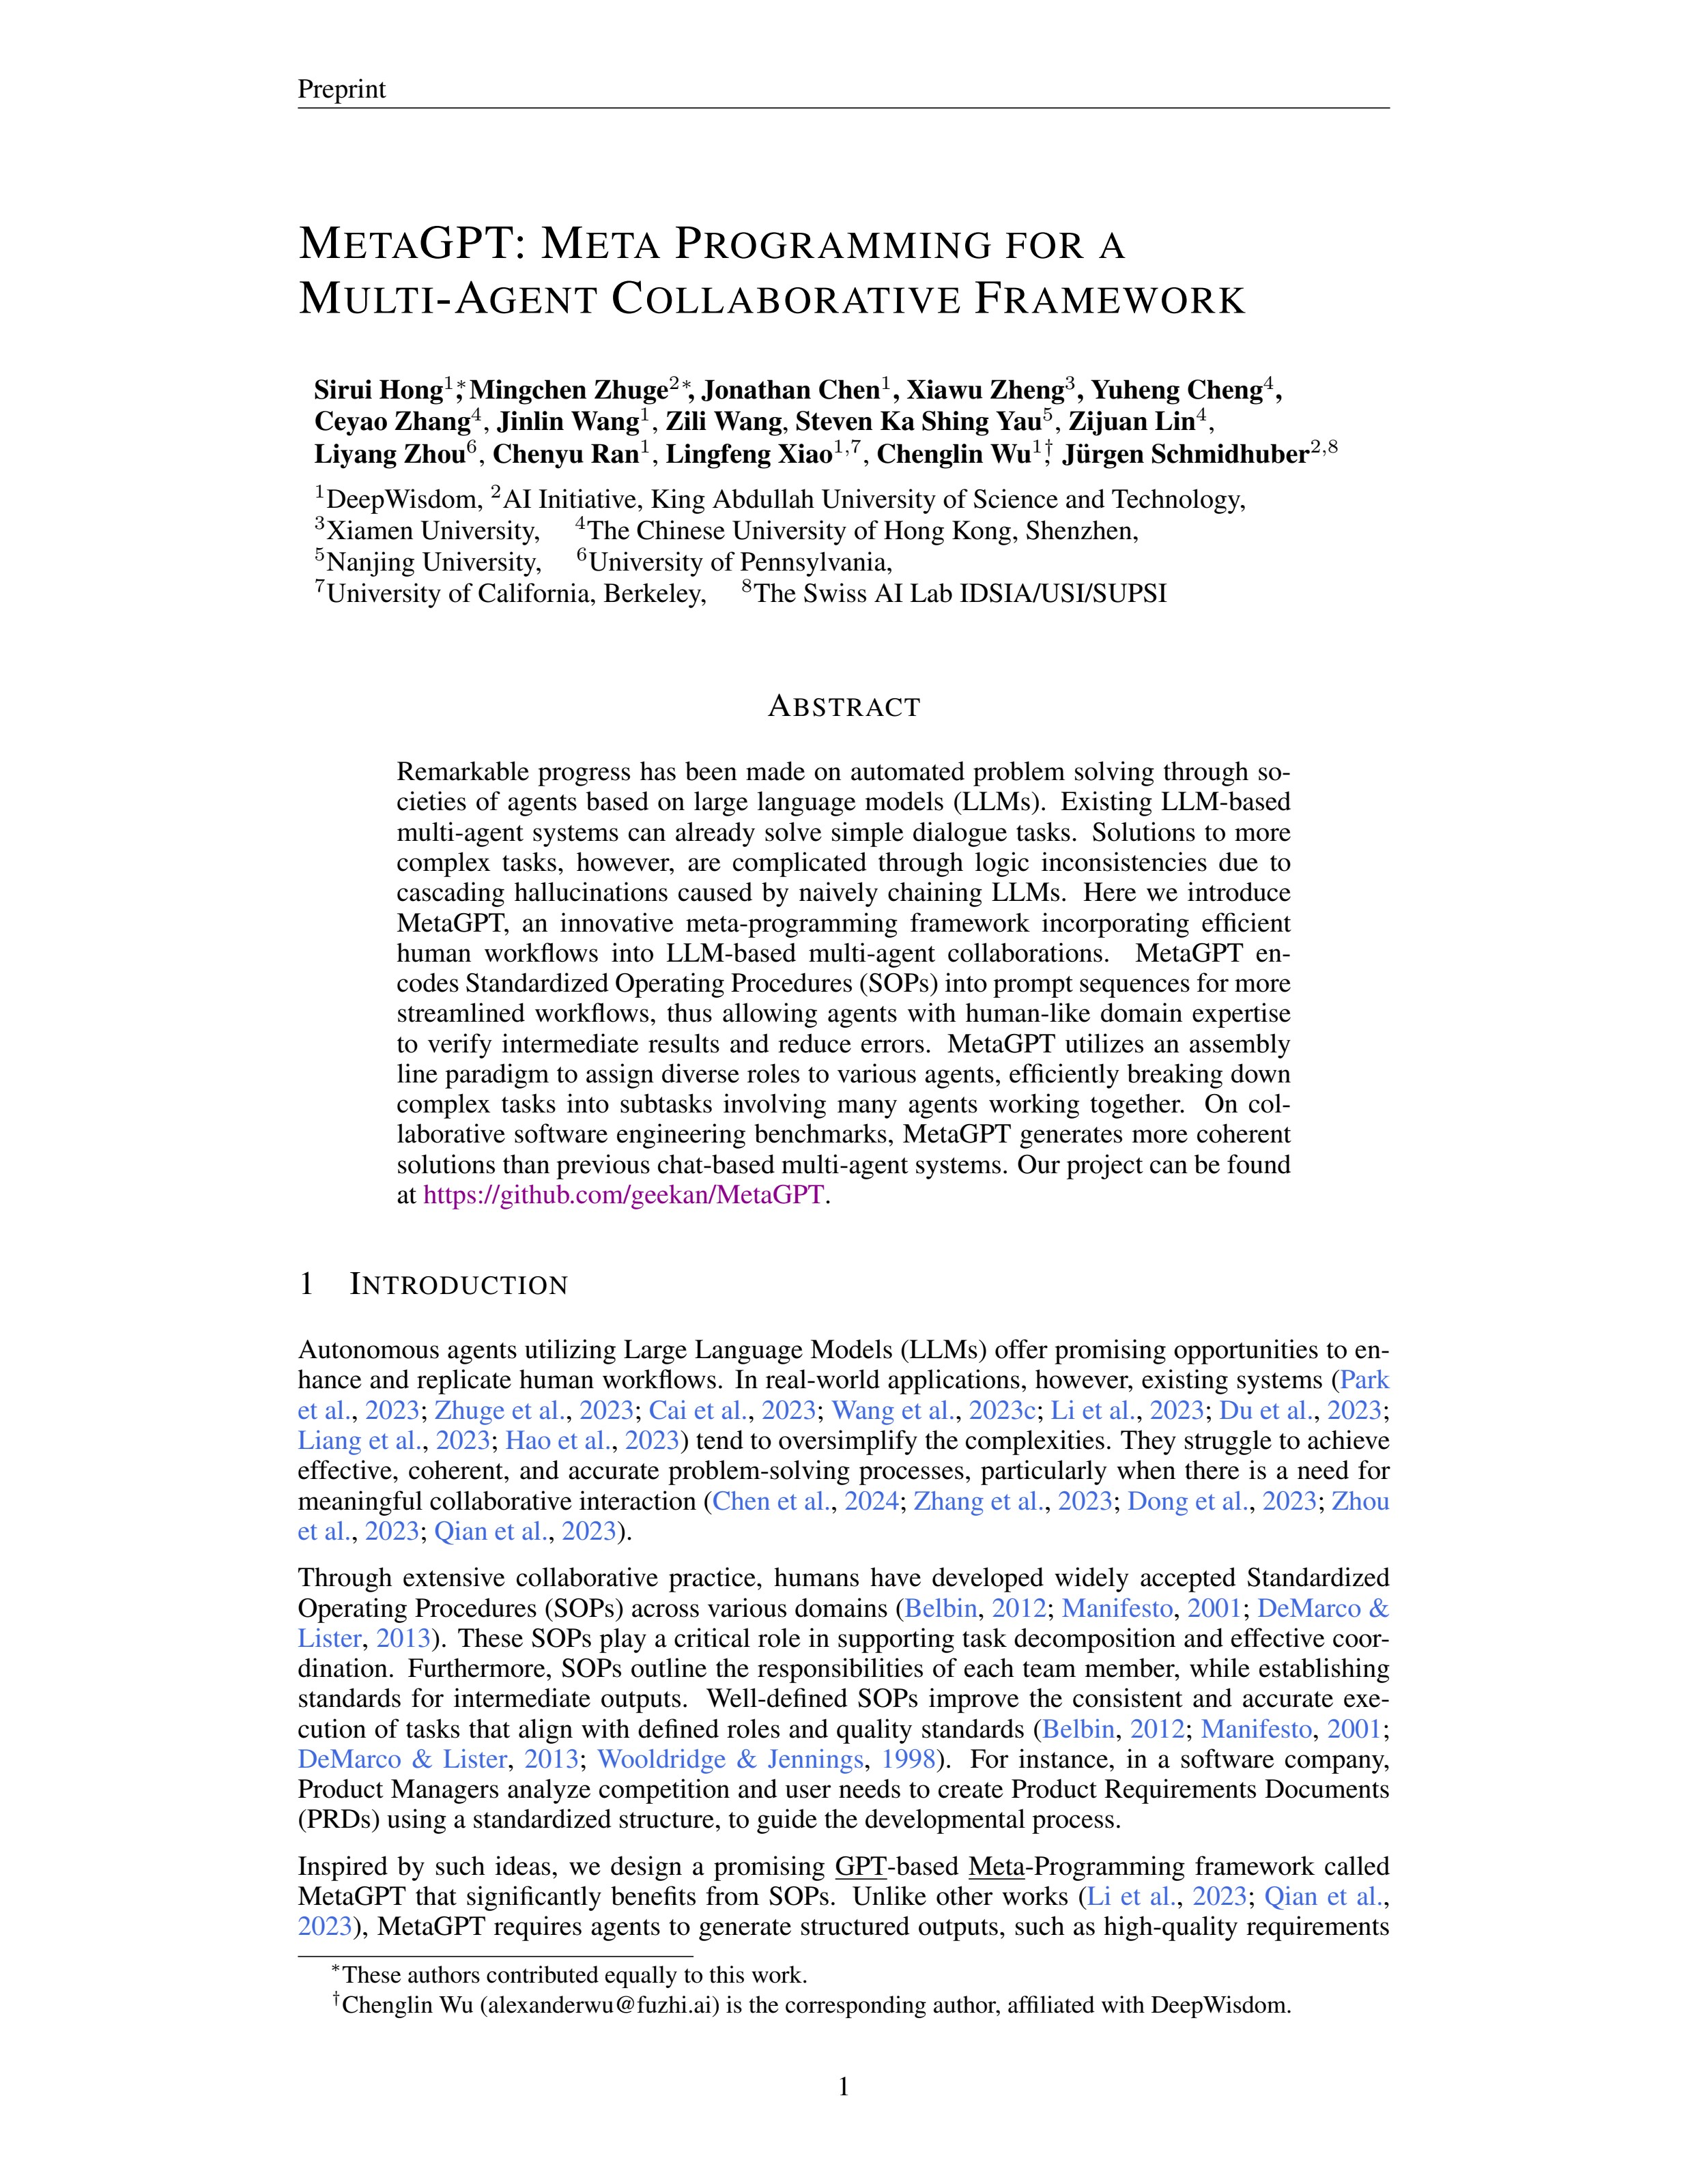

1. Core Experimental Techniques

- Standardized Operating Procedures (SOPs) as Prompted Workflows:
  - Agents are assigned domain-specific roles (e.g., Product Manager, Architect, Engineer, QA) and instructed to produce structured artifacts (PRDs, system design, interface specs) rather than free-form dialogue. 
  - SOPs define responsibility boundaries and expected intermediate outputs, enforcing format and content standards for handoffs.

- Structured Outputs and Document-Based Communication:
  - Inter-agent exchanges use document- and diagram-style outputs (requirements, flow diagrams, interface specs), ensuring that necessary information is recorded and reducing ambiguity from casual chat-style interactions.

- Publish–Subscribe Global Message Pool:
  - A shared message pool stores structured messages published by agents. Agents subscribe to role-relevant channels to retrieve only task-related information, reducing information overload.
  - Agents activate actions when prerequisite dependencies are met, supporting asynchronous yet coordinated execution.

- Assembly-Line Role Decomposition:
  - Tasks are decomposed into an assembly-line of subtasks assigned to specialized agents. This division of labor facilitates systematic requirement decomposition into classes, functions, and tests.

- Executable Feedback Loop and Iterative Programming:
  - Engineers produce code and corresponding unit tests, execute tests, and use runtime feedback to debug and iterate.
  - An explicit limit on retries (e.g., up to 3) bounds iteration; test-driven execution reduces hallucinated but non-executable outputs.

2. Experimental Setup and Datasets

- Benchmarks used:
  - Two public code-generation benchmarks with automated functional tests (HumanEval and MBPP) to measure Pass@k metrics.
  - A custom SoftwareDev dataset of 70 representative software development tasks emphasizing engineering aspects (mini-games, visualization, multi-file projects), with a subset used for comparative evaluation.

- Evaluation Metrics:
  - For automated benchmarks: unbiased Pass@k to quantify functional correctness of top-k generations.
  - For SoftwareDev: human-evaluated executability scores (1–4), cost measures (runtime, token usage, monetary), code statistics (files, LOC), productivity (tokens per line), and human revision cost (number of manual corrections).

- Baselines and Ablations:
  - Comparison against multi-agent frameworks and single-system code models (e.g., chain-based agent systems and popular code LLMs).
  - Ablation of the executable feedback module to measure its contribution.
  - Experiments across different LLM backends (GPT-4, GPT-3.5, and other code models) to evaluate sensitivity to model capability.

3. Key Empirical Findings

- Strong improvements in Pass@1 on HumanEval and MBPP relative to prior approaches, with the system achieving state-of-the-art single-attempt pass rates in the reported experiments.

- The SOP-driven structured communications and document handoffs increased successful multi-file and multi-component code generation compared to chat-based agent chains that rely on informal dialogue.

- The executable feedback loop noticeably improved practical executability and reduced human revision costs. Variants without executable feedback showed lower performance on complex engineering tasks.

- Performance scales with LLM capability: higher-performing LLM backends produce better code; however, the structured multi-agent workflow yields benefits even with weaker backends.

4. Strengths of the Experimental Design

- Realistic engineering focus: Use of multi-file projects, interface specs, and test-driven cycles approximates practical software development workflows more closely than single-function code generation tasks.

- Multi-faceted evaluation: Combining automated functional metrics (Pass@k) with human-centered executability and cost analyses provides a comprehensive assessment of utility.

- Explicit ablations: Removing the executable feedback mechanism and swapping LLM backends helps isolate the contribution of each component.

- Communication controls: The publish–subscribe model and structured outputs mitigate cascading hallucination and information drift common in chat-based multi-agent setups.

5. Limitations and Potential Confounders

- Reproducibility details: Successful replication depends on precise prompt templates, SOP definitions, subscription filters, and environment setup (test harness, dependency resolution). If not fully specified, reproducing results may be difficult.

- Human eval subjectivity: Executability and revision-cost judgments rely on human raters; inter-rater calibration and sample sizes affect reliability.

- Cost and token usage trade-offs: The assembly-line and structured exchange likely increase token consumption and runtime; while productivity metrics are reported, additional analysis of scalability and cost at larger project scales is needed.

- Dependency on LLM quality: While the workflow improves results even with weaker models, the best outcomes require high-capability LLMs, which may limit accessibility.

- Limited domains: The experiments focus on software development; generalization to other domains with different artifact types (e.g., scientific workflows, legal drafting) remains to be validated.

6. Recommendations for Future Experiments

- Detailed ablation studies on SOP granularity: Vary the strictness and format constraints of SOPs to quantify the trade-off between structure and agent creativity.

- Communication bandwidth vs. performance: Measure how reducing or expanding published information affects success rates and token costs.

- Larger-scale, multi-file project benchmarks: Evaluate on bigger projects with dependency graphs, build systems, and CI integration to stress-test coordination mechanisms.

- Automated reproducibility kit: Release precise prompt templates, role definitions, subscription rules, test harness scripts, and environment containers to facilitate replication.

- Cross-domain validation: Apply the same multi-agent SOP framework to other collaborative tasks (e.g., research paper drafting, product design) to assess generality.

- Quantify human oversight reduction: Measure how much manual intervention is required across different task complexities and how that correlates with agent role definitions.

7. Conclusion

The experimental approach combines workflow engineering (SOPs), structured inter-agent documents, publish–subscribe communication, and executable feedback to address key failure modes in multi-agent LLM systems. The ensemble of techniques improves code executability, reduces communication drift, and achieves strong benchmark performance. Future work should focus on rigorous reproducibility, scaling analyses, and broader-domain testing to better understand limits and operational costs.

In [ ]:
ret["response"].response.render()